In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import HTML
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from time import time
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
import torch


In [2]:
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('./Datasets/recorridos-realizados-2018.csv', encoding='latin-1')
len(df)

1457509

In [4]:
# Convertir fecha_hora_retiro a datetime

df.bici_Fecha_hora_retiro = df.bici_Fecha_hora_retiro.apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))
df['date'] = df.bici_Fecha_hora_retiro.apply(lambda x: x.replace(minute=0, second=0))

In [5]:
#limpieza de datos

fecha_limite = pd.to_datetime('2016-08-01 00:00:00')
df_shorten = df[df['date'] >= fecha_limite].copy()
bicis_por_dia = df_shorten.groupby('date').bici_id_usuario.count().resample('D').sum()

In [6]:
# Obtengo minutos de alquiler de bici

parse_duration = lambda duration_str: timedelta(
    hours=int(duration_str.split(':')[0]),
    minutes=int(duration_str.split(':')[1]) if len(duration_str.split(':')) >=2 else 0,
    seconds=int(duration_str.split(':')[2]) if len(duration_str.split(':')) >=3 else 0
)

df_shorten['bici_tiempo_uso_delta'] = df_shorten['bici_tiempo_uso'].apply(lambda x: parse_duration(x))
df_shorten['total_minutes'] = df_shorten['bici_tiempo_uso_delta'].dt.total_seconds() / 60

In [7]:
df_trimmed = df_shorten[df_shorten['date'] <= pd.to_datetime('2017-12-01 23:59:59')].copy()
bicis_por_dia_trimmed = df_trimmed.groupby('date').bici_id_usuario.count().resample('D').sum()

## LSTM 

In [8]:
X = bicis_por_dia_trimmed
#size = int(len(X) * 0.66)
#train, test = X[0:size], X[size:len(X)]
X = pd.DataFrame(X)
X = X.reset_index()

In [39]:
timeseries = X['bici_id_usuario'].values.astype('float32')
#plt.plot(timeseries)
#plt.xticks(rotation=45)
#plt.show()
timeseries = timeseries.reshape(-1, 1)


In [58]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [59]:
train.dtype

dtype('float32')

In [92]:
import torch
from torch.utils.data import IterableDataset, DataLoader

class TimeSeriesDataset(IterableDataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __iter__(self):
        return iter(self.generate_sequences())

    def generate_sequences(self):
        for i in range(len(self.data) - self.sequence_length + 1):
            yield self.data[i:i + self.sequence_length]
 
    def __len__(self):
            return len(self.data) - self.sequence_length + 1

In [93]:

# Define sequence length
sequence_length = 7

# Create IterableDataset instances for train and test datasets
train_dataset = TimeSeriesDataset(train, sequence_length)
test_dataset = TimeSeriesDataset(test, sequence_length)

# Create DataLoader instances for train and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)


In [94]:
train[:8]

array([[1077.],
       [1233.],
       [1249.],
       [1348.],
       [1008.],
       [ 811.],
       [ 804.],
       [ 962.]], dtype=float32)

In [81]:
first_batch = next(iter(train_dataloader))
print(first_batch)

tensor([[[1077.],
         [1233.],
         [1249.],
         [1348.],
         [1008.],
         [ 811.],
         [ 804.]]])


In [86]:
input = first_batch[:, :-1]
input

tensor([[[1077.],
         [1233.],
         [1249.],
         [1348.],
         [1008.],
         [ 811.]]])

In [88]:
target = first_batch[:, 1:]   # Predict all but the first time step
target

tensor([[[1233.],
         [1249.],
         [1348.],
         [1008.],
         [ 811.],
         [ 804.]]])

In [95]:
len(train_dataloader)

320

In [84]:
#for batch in train_dataloader:
#    print(batch.size())  # Assuming each data point in the batch is represented as a tensor
#torch.Size([1, 7, 1])
#one sequence, seven time steps, one feature (batch, sequence, number of features)

In [96]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import IterableDataset, DataLoader

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Check input dimensions
        assert x.dim() == 3, "Input tensor must have 3 dimensions (batch_size, sequence_length, input_size)"
        # Initialize hidden state
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        # Forward pass through LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Take the output of the last time step and pass it through the linear layer
        out = self.fc(out[:, -1, :])
        return out


# Define hyperparameters
input_size = 1  # Assuming univariate time series
hidden_size = 50
output_size = 1
learning_rate = 0.1
num_epochs = 10

# Instantiate the model
model = LSTMModel(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        # Reshape batch to match the expected input shape (batch_size, sequence_length, input_size)
        batch = batch.float()  # Convert batch to float
        # Create input and target sequences for auto-regressive prediction
        input_seq = batch[:, :-1]  # Use all but the last time step as input
        target_seq = batch[:, 1:]   # Predict all but the first time step
        # Forward pass
        output = model(input_seq)
        # Compute loss
        loss = criterion(output, target_seq)
        total_loss += loss.item()
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Print average loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {total_loss / len(train_dataloader):.6f}')




Epoch [1/10], Average Loss: 1529481.159424
Epoch [2/10], Average Loss: 600362.298706
Epoch [3/10], Average Loss: 389657.902014
Epoch [4/10], Average Loss: 363113.031201
Epoch [5/10], Average Loss: 364219.956091
Epoch [6/10], Average Loss: 365800.976746
Epoch [7/10], Average Loss: 366446.025415
Epoch [8/10], Average Loss: 366738.931323
Epoch [9/10], Average Loss: 366916.708362
Epoch [10/10], Average Loss: 367043.165955


In [ ]:

# Now you can iterate over the dataloader in your training loop
for batch in train_dataloader:
    # Create a separate stream for each position in the batch
    batch_streams = zip(*batch)
    for position_stream in batch_streams:
        # Process each position stream as a separate sequence
        # Example: train your LSTM model on each position stream
        pass

### Iterable dataset solution

In [42]:
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, IterableDataset
from itertools import islice

import random 
from itertools import chain, cycle

class MyIterableDataset(IterableDataset):
  def __init__(self, data, batch_size):
    #super(MyIterableDataset, self).__init__()
    self.data = data
    self.batch_size = batch_size

  @property
  def shuffled_data_list(self):
    #import random
    return random.sample(self.data, len(self.data))  # Shuffle the data list

  def process_data(self, data):
    for x in data:
      yield x  # Yield each data point

  def get_stream(self, data):
    return chain.from_iterable(map(self.process_data, cycle(data)))  # Create a stream from data list

  def get_streams(self):
    return zip(*[self.get_stream(self.shuffled_data_list) for _ in range(self.batch_size)])
      
  def __iter__(self):
    return self.get_streams()


In [43]:
test = list(test)
train = list(train)

In [44]:
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from itertools import islice
import torch.nn as nn


# Separate datasets for train and test
train_dataset = MyIterableDataset(train, batch_size=4)
test_dataset = MyIterableDataset(test, batch_size=4)

# Separate dataloaders for train and test 

#train_dataloader = DataLoader(train_dataset, batch_size=None, shuffle=False)
#test_dataloader = DataLoader(test_dataset, batch_size=None, shuffle=False)

for batch in islice(train_dataset, 3):
    print(batch)

(651.0, 1806.0, 2228.0, 1479.0)
(2283.0, 872.0, 1622.0, 1077.0)
(1205.0, 638.0, 2381.0, 1205.0)


In [46]:
# Define the LSTM model
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, batch_first):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=batch_first)
    self.linear = nn.Linear(hidden_size, 1)  # Output layer for single prediction

  def forward(self, x):
    # Pass data through LSTM layers
    lstm_out, _ = self.lstm(x)
    # Get the last output from the sequence (assuming batch_first=True)
    out = lstm_out[:, -1, :]
    # Pass through linear layer for prediction
    prediction = self.linear(out)
    return prediction

# Define hyperparameters
input_size = 1
hidden_size = 50
num_layers = 1
batch_first = True

# Create the model
model = LSTMModel(input_size, hidden_size, num_layers, batch_first)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()  # Mean Squared Error loss


# Training loop (replace with your actual training data)
for epoch in range(10):  # Train for 10 epochs (adjust as needed)
  for inputs in train:  # Assuming your data has labels (modify if not)
    # Clear gradients
    optimizer.zero_grad()

    # Forward pass
    predictions = model(inputs)

    # Calculate loss
    loss = loss_fn(predictions, inputs)  # Assuming labels are the same as inputs

    # Backward pass and update weights
    loss.backward()
    optimizer.step()

    # Print training progress (optional)
    print(f'Epoch [{epoch+1}/{10}], Loss: {loss.item():.4f}')


AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [ ]:

# After training, you can use the model for prediction
new_input = torch.tensor([6])  # Example input for prediction
prediction = model(new_input)
print(f'Prediction for input {new_input.item()}: {prediction.item():.4f}')

In [ ]:
import random
from itertools import islice
import math

class MyIterableDataset(torch.utils.data.IterableDataset):
  def __init__(self, data_list, batch_size=1):
    super(MyIterableDataset, self).__init__()
    self.data_list = data_list
    self.batch_size = batch_size

  @property
  def shuffled_data_list(self):
    import random
    return random.sample(self.data_list, len(self.data_list))  # Shuffle the data list

  def process_data(self, data_list):
    for data in data_list:
      yield data  # Yield each data point

  def get_stream(self, data_list):
    return self.process_data(data_list)  # Create a stream from data list

  def get_streams(self, num_batches):
    streams = []
    for _ in range(num_batches):
      streams.append(self.get_stream(self.shuffled_data_list))  # Generate streams
    return streams

  def __iter__(self):
    worker_info = torch.utils.data.get_worker_info()
    if worker_info is None:
      # Single-process data loading
      for stream in self.get_streams(int(math.ceil(len(self.data_list) / self.batch_size))):
        for data in stream:
          yield data
    else:
      # Distributed data loading
      per_worker = int(math.ceil((len(self.data_list) - self.batch_size) / float(worker_info.num_workers)))
      worker_id = worker_info.id
      start_idx = worker_id * per_worker
      end_idx = min(start_idx + per_worker + self.batch_size, len(self.data_list))
      for data in self.process_data(self.data_list[start_idx:end_idx]):
        yield data

In [68]:
%% script True 
import random 

class MyIterableDataset(IterableDataset):
  def __init__(self, data_list, batch_size):
    #super(MyIterableDataset, self).__init__()
    self.data_list = data_list
    self.batch_size = batch_size

  @property
  def shuffled_data_list(self):
    #import random
    return random.sample(self.data_list, len(self.data_list))  # Shuffle the data list

  def process_data(self, data):
    for x in data_list:
      yield x  # Yield each data point

  def get_stream(self, data_list):
    return chain.from_iterable(map(self.process_data, cycle(data_list)))  # Create a stream from data list

  def get_streams(self):
    return zip(*[self.get_stream(self.shuffled_data_list) for _ in range(self.batch_size)])
      
      
  def __iter__(self):
    return self.get_streams()


UsageError: Cell magic `%%` not found.


### Normal dataset (not iterable)

In [11]:
import torch

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]  # Extract the feature window
        target = dataset[i+1:i+lookback+1]  # Extract the target window (shifted by 1 step)
        X.append(feature)
        y.append(target)
    # Convert lists to PyTorch tensors
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    # Reshape y to add an extra dimension
    #y = y.unsqueeze(-1)
    #X = X.unsqueeze(-1)
    return X, y


In [12]:
train.shape

(326, 1)

In [13]:
#window

lookback=14
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

print(X_train.shape,  y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([312, 14, 1]) torch.Size([312, 14, 1])
torch.Size([148, 14, 1]) torch.Size([148, 14, 1])


In [14]:
import torch.nn as nn

class BikePredModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50,1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [15]:
import torch.optim as optim
import torch.utils.data as data

model = BikePredModel()
optimizer = optim.Adam(model.parameters(), lr=0.5)
loss_fn = nn.MSELoss()
#loss_fn = nn.HuberLoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=64, drop_last=True)

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
X_train = torch.tensor(scaler_x.fit_transform(X_train.squeeze().numpy())[:,:,None])
X_test = torch.tensor(scaler_x.transform(X_test.squeeze().numpy())[:,:,None])

# crear otro scaler
scaler_y = MinMaxScaler()
y_train = torch.tensor(scaler_y.fit_transform(y_train.squeeze().numpy())[:,:,None])
y_test = torch.tensor(scaler_y.transform(y_test.squeeze().numpy())[:,:,None])


#X_test = torch.tensor(scaler.transform(X_test.squeeze().numpy())[:,:,None])

In [18]:

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

train_loss = []
test_loss = []
train_rmse = []
test_rmse = []
gradient_norm = []

n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 100 != 0:
        continue
    
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train)
        train_loss.append(loss_fn(y_pred_train, y_train).item())
        train_rmse.append(np.sqrt(loss_fn(y_pred_train, y_train).item()))

        ## pruebo haciendo inverse transform
        
        
        y_pred_test = model(X_test)
        y_pred_test_inv = torch.tensor(scaler_y.inverse_transform(y_pred_test.squeeze().numpy())[:,:,None])
        test_loss.append(loss_fn(y_pred_test_inv, y_test).item())
        test_rmse.append(np.sqrt(loss_fn(y_pred_test_inv, y_test).item()))
    
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse[-1], test_rmse[-1]))
    print("Epoch %d: train loss %.4f, test loss %.4f" % (epoch, train_loss[-1], test_loss[-1]))


Epoch 0: train RMSE 641.1044, test RMSE 2117112.0135
Epoch 0: train loss 411014.8125, test loss 4482163277824.0000
Epoch 100: train RMSE 643.1830, test RMSE 2121550.0775
Epoch 100: train loss 413684.4062, test loss 4500974731264.0000
Epoch 200: train RMSE 641.9696, test RMSE 2114562.6034
Epoch 200: train loss 412125.0000, test loss 4471375003648.0000
Epoch 300: train RMSE 652.5851, test RMSE 2145899.3206
Epoch 300: train loss 425867.3750, test loss 4604883894272.0000
Epoch 400: train RMSE 652.6410, test RMSE 2141772.3152
Epoch 400: train loss 425940.2500, test loss 4587188649984.0000
Epoch 500: train RMSE 666.7122, test RMSE 2183111.5640
Epoch 500: train loss 444505.0938, test loss 4765976100864.0000
Epoch 600: train RMSE 674.5162, test RMSE 2203012.9048
Epoch 600: train loss 454972.1250, test loss 4853265858560.0000
Epoch 700: train RMSE 681.5019, test RMSE 2219522.7755
Epoch 700: train loss 464444.7812, test loss 4926281351168.0000
Epoch 800: train RMSE 694.5385, test RMSE 2255370.98

### Plot loss, rmse and gradient norms

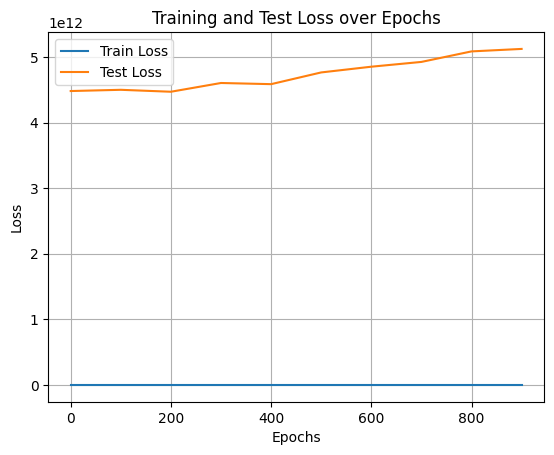

In [20]:
epochs = range(0, n_epochs, 100)

plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, test_loss, label='Test Loss')

plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

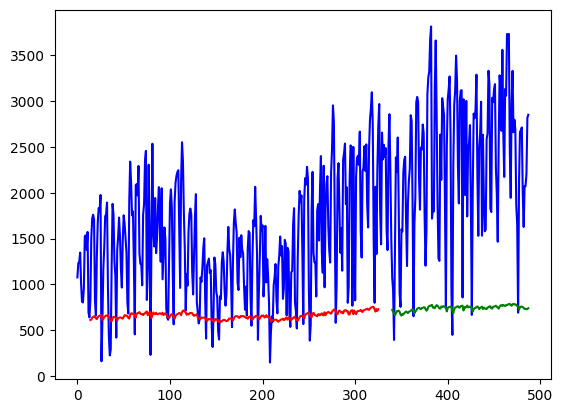

In [21]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries)  * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
  
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()